# Qamomile v0.8.0

---

This release majorly enhances accessibility for a broader audience by adding [tutorials in Japanese](https://jij-inc.github.io/Qamomile/ja/), improves usability by supporting [OMMX v2](https://jij-inc.github.io/ommx/en/introduction.html), and introduces new target quantum SDKs: [CUDA-Q](https://developer.nvidia.com/cuda-q) and [Bloqade-Analog](https://github.com/QuEraComputing/bloqade-analog). We believe that OMMX v2 support is especially significant for both us and users, as OMMX allows us to compare quantum optimization algorithms and classical solvers more easily than before by providing a unified form of optimization problems.

We have other updates with slightly smaller impacts as well. Please have a look at our [releases](https://github.com/Jij-Inc/Qamomile/releases) and individual PRs for more details.

## ✨ New Features

### OMMX v2 Support ([#126](https://github.com/Jij-Inc/Qamomile/pull/126), [#198](https://github.com/Jij-Inc/Qamomile/pull/198))

OMMX v2 brings major performance improvements through a new Rust-based implementation, replacing the previous Protocol Buffer-based approach (see [OMMX Python SDK 2.0.0](https://github.com/Jij-Inc/ommx/blob/main/docs/en/release_note/ommx-2.0.0.md) for more details). This update provides:

  - **Enhanced Performance**: Computational complexity improvements, especially for large-scale problems
  - **Improved API**: More intuitive and AI-friendly API design
  - **Better Type Safety**: Rust-level type checking for more robust optimization problem handling

Note that OMMX v2 brings performance improvements in handling instances, but it does not bring performance improvements on the quantum algorithm side, such as circuit running time.

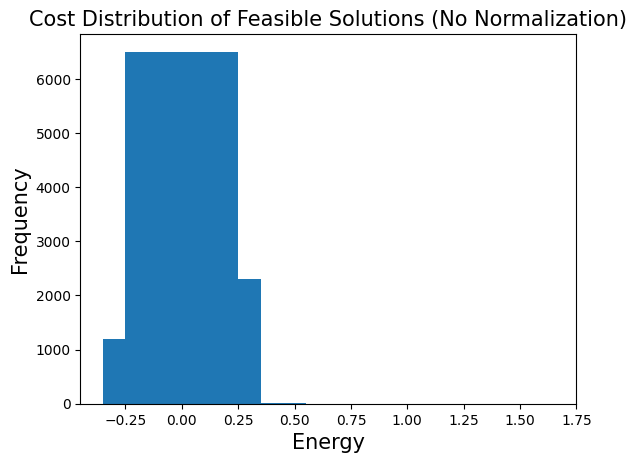

In [1]:
# Import necessary libraries.
from collections import defaultdict

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
import qamomile.qiskit as qm_qk


# Create optimization problem with JijModeling.
Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

# Compile with data as ommx.v1.Instance.
instance_data = {"Q": [[0.1, 0.2, -0.1], [0.2, 0.3, 0.4], [-0.1, 0.4, 0.0]]}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)  # NEW

# Convert to QAOA using Qamomile.
qaoa_converter = qm.qaoa.QAOAConverter(instance)
p = 5
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

# Convert Qamomile circuit and Hamiltonian to Qiskit format.
qk_transpiler = qm_qk.QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# Define cost estimation function using Qiskit primitives.
estimator = qk_pr.StatevectorEstimator()
cost_history = []
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf

# Optimise the QAOA parameters using COBYLA.
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)

# Run the QAOA circuit with the optimised parameters.
qk_circuit.measure_all()
sampler = qk_pr.StatevectorSampler()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])  # NEW

# Create a dictionary to group energies and count their frequencies.
energy_freq = defaultdict(int)
for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1
energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

# Show the cost distribution.
plt.bar(energies, frequencies, width=0.5)
plt.title("Cost Distribution of Feasible Solutions (No Normalization)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

### CUDA-Q Support ([#143](https://github.com/Jij-Inc/Qamomile/pull/143))
CUDA-Q streamlines hybrid application development and promotes productivity and scalability in quantum computing. Now, you can compile your circuits and Hamiltonians in Qamomile format into CUDA-Q format!

In [2]:
import cudaq

from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.cudaq.transpiler import CudaqTranspiler

# Create an instance of the CudaqTranspiler.
cudaq_transpiler = CudaqTranspiler()

# Define a simple quantum circuit using Qamomile.
qc = QamomileCircuit(1)
qc.h(0)
qc.x(0)

# Transpile the circuit using CudaqTranspiler.
transpiled_circuit = cudaq_transpiler.transpile_circuit(qc)

# Draw the transpiled circuit.
print(type(transpiled_circuit))
print(cudaq.draw(transpiled_circuit, []))

# Create a Hamiltonian using Qamomile.
hamiltonian = Hamiltonian()
hamiltonian += X(0) * Z(1)
hamiltonian += Y(0) * Y(1) * Z(2) * X(3) * X(4)

# Transpile the Hamiltonian using CudaqTranspiler.
transpiled_hamiltonian = cudaq_transpiler.transpile_hamiltonian(hamiltonian)
# Show the transpiled hamiltonian.
print(type(transpiled_hamiltonian))
print(transpiled_hamiltonian)

<class 'cudaq.kernel.kernel_builder.PyKernel'>
     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├
     ╰───╯╰───╯

<class 'cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.SpinOperator'>
(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


### Bloqade-Analog Support ([#130](https://github.com/Jij-Inc/Qamomile/pull/130))
Bloqade-Analog is an SDK designed to make writing and analysing the results of analog quantum programs on QuEra's neutral atom quantum computers as seamless and flexible as possible. This support unlocks the power of neutral atom quantum computing with native Bloqade-Analog integration, expanding Qamomile's reach beyond gate-based quantum devices.

Overwriting delta from 2.7 to 1.5


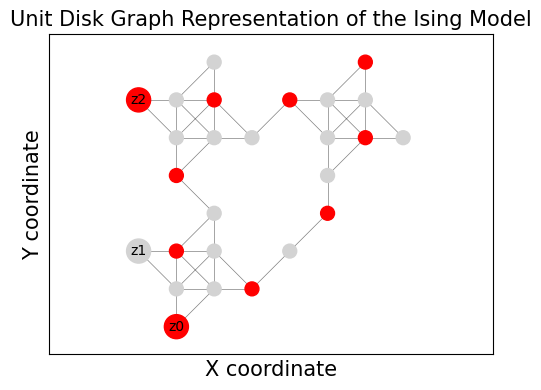

In [4]:
# Import necessary libraries.
import math

from bloqade.analog import start
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.udm import Ising_UnitDiskGraph

# Define a problem.
V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
U = jm.Placeholder("U", ndim=2)
n = jm.BinaryVar("n", shape=(V,))
e = jm.Element("e", belong_to=E)

problem = jm.Problem("QUBO_Hamiltonian")
quadratic_term = jm.sum(e, U[e[0], e[1]] * n[e[0]] * n[e[1]])
problem += quadratic_term

# Compile the problem with data as ommx.v1.Instance.
quad = {(0, 0): -1.2, (1, 1): -3.2, (2, 2): -1.2, (0, 1): 4.0, (0, 2): -2.0, (1, 2): 3.2}
V_val = 3
E_val = np.array(list(quad.keys()), dtype=int)
U_val = np.zeros((V_val, V_val))
for (i, j), Jij in quad.items():
    U_val[i, j] = U_val[j, i] = Jij
instance = {"V": V_val, "E": E_val, "U": U_val}
compiled_instance: ommx.v1.Instance = jm.Interpreter(instance).eval_problem(problem)

# Map the Ising model into UnitDiskGraph class.
udm_converter = QAOAConverter(compiled_instance)
ising_model = udm_converter.ising_encode()
udg = Ising_UnitDiskGraph(ising_model)

# Get locations and weights from the UDM.
LOCATION_SCALE = 5.0  # Adjust based on desired blockade radius and hardware
locations = udg.qubo_result.qubo_grid_to_locations(LOCATION_SCALE)
weights = udg.qubo_result.qubo_result_to_weights()

# Define the program.
def solve_ising_bloqade(locations, weights, delta_max=60.0, Omega_max=15.0, t_max=4.0):
    locations_array = np.array(locations)
    centroid = locations_array.mean(axis=0)
    centered_locations = locations_array - centroid
    locations = list(map(tuple, centered_locations))

    lw = len(weights)
    weights_norm = [x / max(weights) for x in weights]

    def sine_waveform(t):
        return Omega_max * math.sin(math.pi * t / t_max) ** 2

    def linear_detune_waveform(t):
        return delta_max * (2 * t / t_max - 1)

    program = (
        start.add_position(locations)
        .rydberg.detuning.scale(weights_norm)
        .fn(linear_detune_waveform, t_max)
        .amplitude.uniform.fn(sine_waveform, t_max)
    )

    return program
program = solve_ising_bloqade(locations, weights)

# Run the simulation.
blockade_radius = LOCATION_SCALE * 1.5  # blockade radius is set to cover the diagonal node (1: sqrt(2))
emu_results = program.bloqade.python().run(
    shots=10000, solver_name="dop853", blockade_radius=blockade_radius
)
report = emu_results.report()
counts = report.counts()[0]
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

# Visualise the results using NetworkX and Matplotlib.
G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")
# Color and size nodes based on bit value
bitstr = list(sorted_counts.items())[:2][0][0]
node_colors = ["red" if b == "0" else "lightgray" for b in bitstr]
node_sizes = [300 if i in udg.pins else 100 for i in G_vis.nodes()]

plt.figure(figsize=(5, 4))
nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# Label the pins with their original variable index
pin_labels = {pin: f"z{i}" for i, pin in enumerate(udg.pins)}  # Use z_i for Ising spins
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # Ensure aspect ratio is maintained
plt.tight_layout()
plt.show()

## 🐛 Bug Fixes

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for details.

## 🛠️ Other Changes and Improvements

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for details.

## 💬 Feedback
With these new features, Qamomile becomes a powerful tool for enabling users to access several quantum SDKs in the same way and compare the results with classical solvers. Try out Qamomile 0.8.0!


Please submit any feedback or bug reports to [GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues).